# Gen Graph Visualization Example

This notebook demonstrates how to visualize genomic graphs using the Gen Python API with the updated dictionary-based node and edge positions.

## Setup

First, let's import the necessary libraries and initialize a repository.

In [1]:
import gen
from gen.helpers import Repository
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Initialize repository
repo = Repository()
print(f"Repository initialized with database at: {repo.db_path}")

Repository initialized with database at: /Users/bvh/Git/gen/.gen/default.db


## Load a Graph

Let's load a graph from the repository and create a layout for visualization.

In [2]:
# Get available collections
collections = repo.query("SELECT DISTINCT collection_name FROM block_groups")
print("Available collections:")
for collection in collections:
    print(f"- {collection[0]}")

# Select a collection to visualize
collection_name = collections[0][0] if collections else None

if not collection_name:
    print("No collections available. You need to create or import a graph first.")
else:
    # Load the graph
    graph = repo.get_graph(collection_name=collection_name)
    print(f"Loaded graph: {graph}")
    
    # Create a layout
    layout = graph.create_layout()
    layout.create_scaled_layout(label_width=100, scale=20)
    print("Created layout for visualization")

Available collections:
- default
- default/foo
Loaded graph: <gen.helpers.Graph object at 0x1133d67b0>
Created layout for visualization


## Basic Visualization with Matplotlib

Now let's visualize the graph using the dictionary-based node and edge positions.

In [3]:
def visualize_graph_with_matplotlib(layout):
    # Get node and edge positions
    node_positions = layout.get_node_positions()
    edge_positions = layout.get_edge_positions()
    
    # Create figure
    plt.figure(figsize=(12, 8))
    
    # Plot edges
    for edge_id, ((x1, y1), (x2, y2)) in edge_positions.items():
        plt.plot([x1, x2], [y1, y2], 'k-', alpha=0.6, linewidth=1)
    
    # Plot nodes
    for node_id, (x, y) in node_positions.items():
        plt.scatter(x, y, s=100, c='skyblue', edgecolors='navy', zorder=10)
        # Add node ID as label (using just the node_id part for simplicity)
        plt.text(x, y, str(node_id[1]), fontsize=8, ha='center', va='center', zorder=11)
    
    plt.title(f"Graph Visualization")
    plt.axis('equal')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Visualize if we have a graph
if 'layout' in locals():
    visualize_graph_with_matplotlib(layout)

TypeError: float() argument must be a string or a real number, not 'tuple'

Error in callback <function _draw_all_if_interactive at 0x112f660c0> (for post_execute), with arguments args (),kwargs {}:


TypeError: float() argument must be a string or a real number, not 'tuple'

TypeError: float() argument must be a string or a real number, not 'tuple'

<Figure size 1200x800 with 1 Axes>

## Advanced Visualization with NetworkX

We can also convert the graph to NetworkX format for more advanced visualization and analysis.

/var/folders/q4/bcg4hckj0lj5n4tyd0sw3jtr0000gq/T/ipykernel_13732/590450730.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('tab10', len(unique_blocks))


ValueError: 'c' argument has 3 elements, which is inconsistent with 'x' and 'y' with size 6.

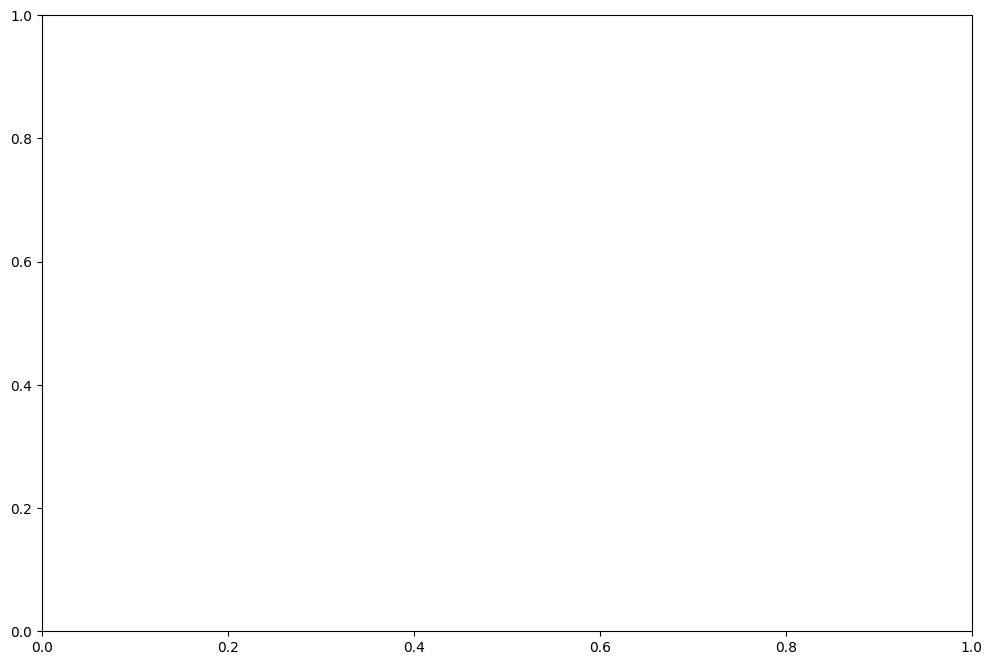

In [4]:
def convert_to_networkx(layout):
    # Get node and edge positions
    node_positions = layout.get_node_positions()
    edge_positions = layout.get_edge_positions()
    
    # Create NetworkX graph
    G = nx.DiGraph()
    
    # Add nodes with positions
    for node_id, pos in node_positions.items():
        # Use the full node_id tuple as the node identifier
        G.add_node(node_id, pos=pos, block_id=node_id[0], node_id=node_id[1], 
                  seq_start=node_id[2], seq_end=node_id[3])
    
    # Add edges
    for (src, dst), _ in edge_positions.items():
        G.add_edge(src, dst)
    
    return G

def visualize_with_networkx(layout):
    # Convert to NetworkX
    G = convert_to_networkx(layout)
    
    # Get positions
    pos = nx.get_node_attributes(G, 'pos')
    
    # Create figure
    plt.figure(figsize=(12, 8))
    
    # Draw the graph
    nx.draw_networkx_edges(G, pos, alpha=0.6, width=1)
    
    # Draw nodes with colors based on block_id
    block_ids = [data['block_id'] for _, data in G.nodes(data=True)]
    unique_blocks = list(set(block_ids))
    color_map = plt.cm.get_cmap('tab10', len(unique_blocks))
    
    node_colors = [color_map(unique_blocks.index(data['block_id'])) for _, data in G.nodes(data=True)]
    nx.draw_networkx_nodes(G, pos, node_size=100, node_color=node_colors, edgecolors='navy')
    
    # Add labels (just node_id for simplicity)
    labels = {node: str(data['node_id']) for node, data in G.nodes(data=True)}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=8)
    
    # Add a legend for block_ids
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map(i), 
                          markersize=10, label=f'Block {block_id}') 
               for i, block_id in enumerate(unique_blocks)]
    plt.legend(handles=handles, title='Block IDs', loc='upper right')
    
    plt.title("Graph Visualization with NetworkX")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    return G

# Visualize if we have a graph
if 'layout' in locals():
    G = visualize_with_networkx(layout)

## Graph Analysis with NetworkX

Now that we have the graph in NetworkX format, we can perform various analyses.

In [5]:
if 'G' in locals():
    # Basic graph statistics
    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")
    
    # Degree distribution
    degrees = [d for _, d in G.degree()]
    plt.figure(figsize=(8, 5))
    plt.hist(degrees, bins=range(max(degrees)+2), alpha=0.7)
    plt.title('Node Degree Distribution')
    plt.xlabel('Degree')
    plt.ylabel('Count')
    plt.grid(alpha=0.3)
    plt.show()
    
    # Identify important nodes
    if len(G) > 0:
        # Calculate betweenness centrality
        betweenness = nx.betweenness_centrality(G)
        top_nodes = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:5]
        
        print("\nTop nodes by betweenness centrality:")
        for node, score in top_nodes:
            print(f"Node {node}: {score:.4f}")
        
        # Identify paths
        if len(G) > 1:
            # Find longest path
            try:
                # Convert to undirected for finding diameter
                UG = G.to_undirected()
                # Find the two nodes that are farthest apart
                farthest_nodes = nx.diameter(UG, e=None)
                print(f"\nGraph diameter: {farthest_nodes}")
            except nx.NetworkXError:
                print("\nGraph is not connected, cannot compute diameter")

## Interactive Visualization with Plotly

For larger graphs, an interactive visualization can be more useful.

In [6]:
try:
    import plotly.graph_objects as go
    
    def visualize_with_plotly(layout):
        # Get node and edge positions
        node_positions = layout.get_node_positions()
        edge_positions = layout.get_edge_positions()
        
        # Prepare node data
        node_x = []
        node_y = []
        node_text = []
        node_block_ids = []
        
        for node_id, (x, y) in node_positions.items():
            node_x.append(x)
            node_y.append(y)
            node_text.append(f"Block: {node_id[0]}, Node: {node_id[1]}, Range: {node_id[2]}-{node_id[3]}")
            node_block_ids.append(node_id[0])
        
        # Prepare edge data
        edge_x = []
        edge_y = []
        
        for _, ((x1, y1), (x2, y2)) in edge_positions.items():
            edge_x.extend([x1, x2, None])
            edge_y.extend([y1, y2, None])
        
        # Create edge trace
        edge_trace = go.Scatter(
            x=edge_x, y=edge_y,
            line=dict(width=0.5, color='#888'),
            hoverinfo='none',
            mode='lines')
        
        # Create node trace
        unique_blocks = list(set(node_block_ids))
        colors = [f'rgb({int(r*255)},{int(g*255)},{int(b*255)})' 
                 for r, g, b, _ in plt.cm.tab10(np.linspace(0, 1, len(unique_blocks)))]
        
        node_colors = [colors[unique_blocks.index(block_id)] for block_id in node_block_ids]
        
        node_trace = go.Scatter(
            x=node_x, y=node_y,
            mode='markers',
            hoverinfo='text',
            text=node_text,
            marker=dict(
                showscale=False,
                color=node_colors,
                size=10,
                line_width=2))
        
        # Create figure
        fig = go.Figure(data=[edge_trace, node_trace],
                     layout=go.Layout(
                        title='Interactive Graph Visualization',
                        titlefont_size=16,
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=20,l=5,r=5,t=40),
                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                        )
        
        # Add legend
        for i, block_id in enumerate(unique_blocks):
            fig.add_trace(go.Scatter(
                x=[None], y=[None],
                mode='markers',
                marker=dict(size=10, color=colors[i]),
                showlegend=True,
                name=f'Block {block_id}'
            ))
        
        fig.show()
    
    # Visualize if we have a graph
    if 'layout' in locals():
        visualize_with_plotly(layout)
        
except ImportError:
    print("Plotly not installed. Install with: pip install plotly")

Plotly not installed. Install with: pip install plotly


## Conclusion

This notebook demonstrated how to visualize genomic graphs using the Gen Python API with the updated dictionary-based node and edge positions. The dictionary format makes it much easier to work with the graph data in Python and integrate with visualization libraries like Matplotlib, NetworkX, and Plotly.